## NGS processing pipeline for RNAI libraries
#### V. Pinheiro - v. 0.1 (10/23)

This relates to our attempt at sampling individual loops in RNAI with sequence and length variation. It is clear, even from a coarse inspection of the NGS data obtained (Alisha's thesis), that the sequence space of permissible (i.e. functional) RNAI sequences far outstrips current models of how RNAI functions in vivo.
Initial steps, not shown here (see Alisha's thesis), looked at the combined data per loop and at the re-sampling of single libraries. Where tested, resampling indicated that any biases in the data were reproducible. Nevertheless, it was also clear that combining libraries per loop was not a suitable strategy for analysis: High sequence (length and composition) and structure variation, together with undersampling of the library meant that little information could be gathered beyond total counts.
> Ann-Celine is testing the highest count sequences isolated from LoopI

> Marelene is looking at the stem and loop length relationship

Here, I try to organise the subsequent analysis exploration and clarify the rationale for subsequent hypothesis testing. A key hypothesis to test is the dependency of stem and loop lengths with plasmid copy number (as we suggested in the initial RNAI engineering paper). Other hypotheses may emerge from the data as we investigate sequence and structural variation.


In [32]:
## Packages needed to run the data clean up
using DataFrames
using CSV
using FASTX
using BioAlignments
using BioSequences
using Random
using StatsBase
using StatsPlots
using Combinatorics
using ViennaRNA
using Unitful
using Clustering
using PlotRNA
using DelimitedFiles


# Contents
__Preparing NGS data__
* [functions](#prep_funct)
* [LoopI parameters](#LoopI_para)
* [filtering NGS data to remove NGS errors + impact of filtering](#NGSerror_fil)

__Adding RNA structural data to isolated seq__
* [using ViennaRNA](#ViennaRNA)
* [function to generate structural data](#gen_struc_data)
    * [__Saving results:__ Dataframe with Structural data](#save_struc)
* [filtering for seq with wanted length and length one base shorter + impact of filtering](#filter_lengthClean)
    * [__Saving results:__ Dataframe with filtered seq length + Structural data](#save_dataClean)

__Marlene: Creating structural data for the whole data obtained by NGS__
* [Added the structural data for the WT-seq](#WT_structure)
* [filtered the LoopI structure of the seq (structure factors WT-downstream, as LoopI was just cut off from whole structure-string)](#filter_LoopI)

__Marlene: Analysis of bracket dot structure__
* [Count brackets and dots in Loop 1: x-x-x == [(-.-)] and includes it into the dataframe](#count_3number_scaffold)
    * [created function that counts all the seq with the same three-number-scaffold and sorts them](#count_same3number)
    * [created filter to search for seq with same three-number-scaffold by showing a dataframe](#filterseq_same3number)
* [functions that can be used to analyse structure including bulges](#funct_LoopStems)
    * [implementing the detailed LoopI-description](#LoopI_descript)
    * [creating Vectors with ceratin LoopI-description to search in the dataframe](#search_LoopI)
    
__2. Structure may be linked to origin viability__

## Preparing NGS data
This routine opens NGS data in FASTA format, identifies sequences with the expected hairpins, isolates the hairpins, computes counts, and implements a simple frequency based filtering to remove likely NGS errors. Wild-type RNAI sequences, expected here only as a contaminant is removed.

<a id='prep_funct'></a>

In [33]:
## All functions are summarised here for clarity and code efficiency

# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end

# Uses string patterns to isolate LoopI relevant sequences
function isolate_hairpin(File::String, upstream::String, downstream::String)
    full_seq = []
    all_seq = load_fasta_file(File)

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end] # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1] # finds the end of stem 1
            # the processing above must always be checked to ensure single base duplication or
            # deletion is not being accidentally introduced 
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end    

# used to convert individual NGS reads into a table containing the counts of individual sequences
function instance_to_count(library, wild_type)
    # Converts the data to a dictionary to allow de-duplication
    NGS_processing = Dict{String, Int64}()
    NGS_clean = DataFrame([[],[],[],[], []],["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])

    for i = 1: size(library, 1) # de-duplication process
        if haskey(NGS_processing, library[i])
            NGS_processing[library[i]] += 1
        else
            NGS_processing[library[i]] = 1
        end
    end

    # Remaps the dictionary to a DataFrame for subsequent analysis
    for (key, value) ∈ NGS_processing   # converts dictionary to DataFrame
        entry = DataFrame([[0], [key], [length(key)], [value], ["false"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
        append!(NGS_clean, entry)
    end
    
    sort!(NGS_clean, :Count, rev=true)
    
    ## Identifies the WT sequence
    for n = 1:size(NGS_clean, 1)
    NGS_clean.Sequence_number[n] = n
        if NGS_clean.LoopI[n] == wild_type
            NGS_clean.WT[n] = "WT"
        end
    end
    
    return NGS_clean
end

# Generates all possible variants within a given Hamming distance
function hamming(sequence::String, distance::Int)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T']
   

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end


    #return output
    return unique(output)
end

# Takes the processed NGS DataFrame and uses a frequency-based algorithm to remove possible sequencing errors
# and the wild-type from the DataFrame
function clustering_errors(start_library, wildtype, subst_rate)
    for i = 1: size(start_library, 1)
        if start_library.WT[i] == "WT"
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(wildtype, 1)
        
            for j = (seed_seq+1): size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        
        elseif start_library.WT[i] == "false" && start_library.Count[i] * subst_rate >= 1.0
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(start_library.LoopI[i], 1)
        
            for j = seed_seq+1:size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        end
    end

    Clustered = filter(:WT => x -> x == "false", start_library)
    return Clustered
end  

clustering_errors (generic function with 1 method)

<a id='LoopI_para'></a>

In [34]:
## Loop1 parameters
upstream = "CGTAATCTGCTGCTTGCAAA"
downstream = "CGGATCAAGAG"
wildtype = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"


"ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"

<a id='NGSerror_fil'></a>

In [35]:
file_name = "Old_large_Loop1_rc.fasta"

lib_pre = instance_to_count(isolate_hairpin(file_name, upstream, downstream),wildtype);
#lib_filtered = clustering_errors(lib_pre, wildtype, 0.005);
lib_filtered = lib_pre

Row,Sequence_number,LoopI,Loop_length,Count,WT
,Any,Any,Any,Any,Any
1,1,ACAAAAAAACCACCGGCGGTGGTTTGTTTGCC,32,1355,false
2,2,ACAAAAAAACCACCGGGCGGTGGTTTGTTTGCC,33,626,false
3,3,ACAAAAAAACCACCGAGCGGTGGTTTGTTTGCC,33,361,false
4,4,ACAAAAAAACCACCGGGGCGGTGGTTTGTTTGCC,34,146,false
5,5,ACAAAAAAACCACCGGTGCGGTGGTTTGTTTGCC,34,116,false
6,6,ACAAAAAAACCACCGGCGCGGTGGTTTGTTTGCC,34,76,false
7,7,ACAAAAAAACCACCGATGCGGTGGTTTGTTTGCC,34,74,false
8,8,ACAAAAAAACCACCGAGGCGGTGGTTTGTTTGCC,34,69,false
9,9,ACAAAAAAACCACCGGAGCGGTGGTTTGTTTGCC,34,68,false


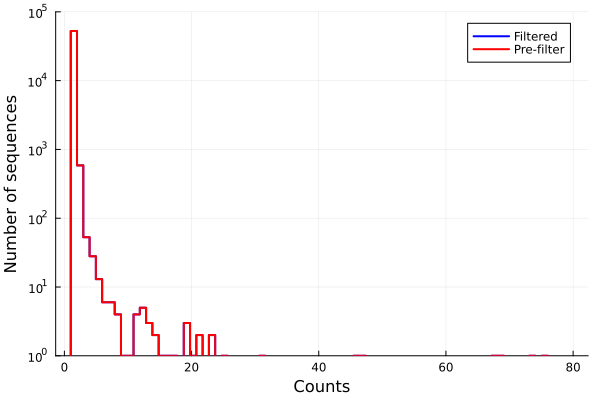

In [36]:
## Looking at the impact of the filtering
his_range = range(1, 80, length=81)
stephist(lib_filtered.Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Filtered")
stephist!(lib_pre.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:red, labels="Pre-filter")

The shape of the curve above is informative. The more a library is oversampled, the more a flat distribution or peak in the data should be seen. In the library data shown above (LoopI, short library), a rapid decline in counts is observed in the data, indicating that sampling is still significantly below library size. Conclusions of the analyses must remain limited to those that can be made from small samples of a large population.
In addition, it is possible to estimate the impact of the frequency-based filtering, which removes some unique or rare observations that are highly similar to more frequent sequences and are therefore likely to be emerging from NGS errors. In the library data shown, the filtering has minimal effect (lines are overlapping) since most represented sequences still have relatively low count.

## Adding RNA structural data to the isolated sequences
We are using here ViennaRNA for the prediction of structural parameters, but other algorithms are available

<a id='ViennaRNA'></a>

In [37]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

## Sequence missing from LoopI to generate the full-length RNAI
downstream_RNAI = "GGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

"GGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

<a id='gen_struc_data'></a>

In [38]:
## All functions are summarised here for clarity and code efficiency

# generating structural data 
function rna_details(dataframe::DataFrame, downstream::String)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = dataframe.LoopI[n] * downstream
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end

rna_details (generic function with 1 method)

In [18]:
WT = lib_filtered[10,:]

Row,Sequence_number,LoopI,Loop_length,Count,WT
,Any,Any,Any,Any,Any
10,10,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT


In [19]:
## Adding structural information to the dataframe
#lib_analysis = rna_details(lib_filtered, downstream_RNAI)

WT_analysis = DataFrame([[0], ["ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"], [38], [47], ["WT"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
WT_analysis = rna_details(WT_analysis, downstream_RNAI)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,Int64,Int64,String,String,Float32,Float32,Int64,Int64
1,0,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0


#### Convenient point for saving partial results and for restarting later analysis

<a id='save_struc'></a>

In [39]:
#save_name = "Processed_" * file_name[1:end-6] * ".csv"

## Saving results
#CSV.write(save_name, lib_analysis)

## Opening saved results
file_name = "Processed_Old_large_Loop1_rc.csv"
lib_analysis = CSV.read(file_name, DataFrame);
#lib_analysis = CSV.read(save_name, DataFrame);


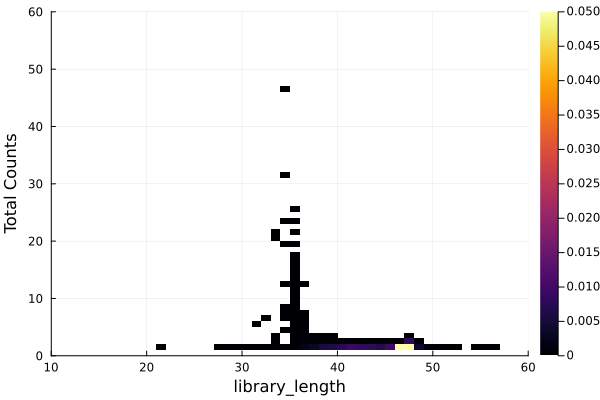

In [40]:
## Looking at the relationship between the frequency of a sequence in the population and its length
hisy_range = range(0, 60, length=61)
hisx_range = range(10, 60, length=51)
histogram2d(lib_analysis.Loop_length, lib_analysis.Count, xlabel = "library_length", ylabel = "Total Counts",
    bins = (hisx_range,hisy_range), show_empty_bins=false, normalize=:pdf, clim=(0,0.05))

Significant deviation from the design length can have a number of sources. It may be the result of NGS errors (including sample preparation), it may be the result of functional constraints, and it may be a consequence of library assembly (whether from PCR or from starting oligonucleotides).
It is possible that greater deviations from the design may have function but for the purposes of analysis, only the design length will be considered here.

<a id='filter_lengthClean'></a>

In [41]:
libAnalysisClean = filter(:Loop_length => n -> n == 46 || n == 47, lib_analysis)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,Int64,Int64,Bool,String,Float64,Float64,Int64,Int64
1,99,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


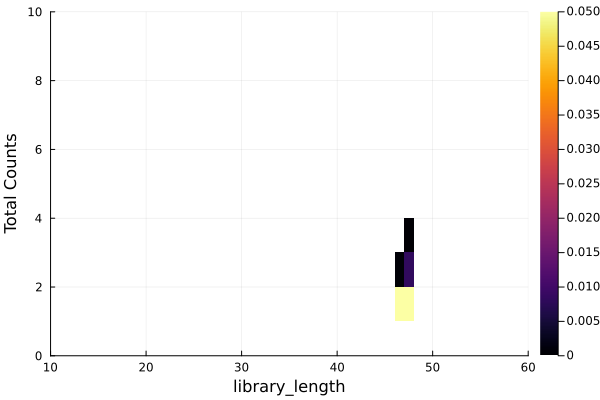

In [42]:
## Looking at the impact of the filtering
hisy_range = range(0, 10, length=11)
hisx_range = range(10, 60, length=51)
histogram2d(libAnalysisClean.Loop_length, libAnalysisClean.Count, xlabel = "library_length", ylabel = "Total Counts",
    bins = (hisx_range,hisy_range), show_empty_bins=false, normalize=:pdf, clim=(0,0.05))

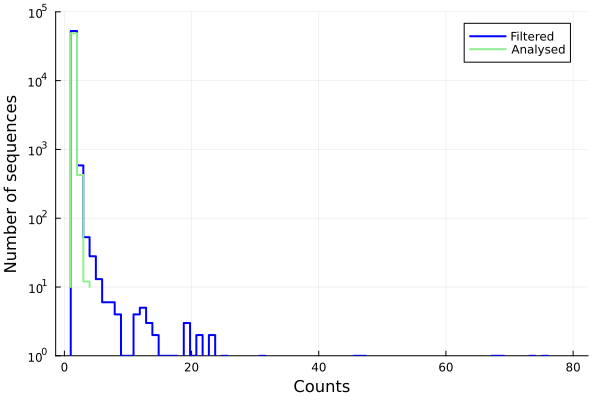

In [43]:
## Looking at the impact of the filtering by length on the population
his_range = range(1, 80, length=81)
stephist(lib_filtered.Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Filtered")
stephist!(libAnalysisClean.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:lightgreen, labels="Analysed")

In the library data shown above (LoopI, short library), the original library design (and sequences including 1 deletion that are the most likely to emerge in library assembly) remains the majority of the population. 

#### Convenient point for saving partial results and for restarting later analysis

<a id='save_dataClean'></a>

In [44]:
#save_name = "AnalysisReady_" * file_name[1:end-6] * ".csv"


## Saving results
#CSV.write(save_name, libAnalysisClean)

## Opening saved results
save_name = "AnalysisReady_Old_large_Loop1_rc.csv"
libAnalysisClean = CSV.read(save_name, DataFrame);


# Marlene: Creating structural data for the whole data obtained by NGS
__NGS-data, all three hairpins__
* Create structural data for the whole NGS data
* filter the LoopI structure from the whole generated structure
* Count brakets and dots in Loop 1: x-x-x == [(-.-)] and includes it into the dataframe


__NGS-data + WT-downstream__
* [generated strcutural data for NGS-data](#create_NGSlib)
* [Added the structural data for the WT-seq](#WT_structure)
* [filtered the LoopI structure of the seq (structure factors WT-downstream, as LoopI was just cut off from whole structure-string)](#filter_LoopI)

→ [then further analysis of braket dot structure (next chapter)](#detailed_structure)

<a id='create_NGSlib'></a>

In [46]:
# Creating a dataframe with all the Sequences detected during the NGS.
lib_pre_NGS = instance_to_count(isolate_hairpin("Old_large_Loop1_rc.fasta", upstream, downstream),wildtype);
lib_filtered_NGS = clustering_errors(lib_pre_NGS, wildtype, 0.005);

In [47]:
# generating structural data 
function rna_details_NGSall(dataframe::DataFrame)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = dataframe.LoopI[n]
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end

rna_details_NGSall (generic function with 1 method)

In [48]:
## Adding structural information to the dataframe
lib_analysis_NGS = rna_details_NGSall(lib_filtered_NGS)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,Any,String,Float32,Float32,Int64,Int64
1,1,ACAAAAAAACCACCGGCGGTGGTTTGTTTGCC,32,1387,false,.((((.((((((((...)))))))).))))..,-11.5,0.977035,0,0
2,2,ACAAAAAAACCACCGGGCGGTGGTTTGTTTGCC,33,649,false,.((((.((((((((....)))))))).))))..,-13.9,0.899893,0,0
3,3,ACAAAAAAACCACCGAGCGGTGGTTTGTTTGCC,33,367,false,.((((.((((((((....)))))))).))))..,-13.9,0.899889,0,0
4,4,ACAAAAAAACCACCGGGGCGGTGGTTTGTTTGCC,34,146,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0
5,5,ACAAAAAAACCACCGGTGCGGTGGTTTGTTTGCC,34,116,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0
6,6,ACAAAAAAACCACCGGCGCGGTGGTTTGTTTGCC,34,76,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0
7,7,ACAAAAAAACCACCGATGCGGTGGTTTGTTTGCC,34,74,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0
8,8,ACAAAAAAACCACCGAGGCGGTGGTTTGTTTGCC,34,69,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0
9,9,ACAAAAAAACCACCGGAGCGGTGGTTTGTTTGCC,34,68,false,.((((.((((((((.....)))))))).))))..,-13.9,1.39903,0,0


In [26]:
save_name = "Processed_NGSall" * file_name[1:end-6] * ".csv"

## Saving results
CSV.write(save_name, lib_analysis)

## Opening saved results
#file_name = "Processed_NGSallProcessed_Old_large_Loop1_.csv"
NGSall_lib_analysis = CSV.read(file_name, DataFrame);
return NGSall_lib_analysis


LoadError: UndefVarError: `lib_analysis` not defined

In [34]:
#NGSall_libAnalysisClean = filter(:Loop_length => n -> n == 46 || n == 47, NGSall_lib_analysis)
NGSall_libAnalysisClean = vcat(libAnalysisClean, WT_analysis)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,99,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


In [45]:
Loop1_structure = DataFrame([[],[]],["Sequence_number", "MFE_SUBstructure"])

for n = 1: (size(NGSall_libAnalysisClean, 1)-1)
    seq_num = NGSall_libAnalysisClean.Sequence_number[n]
    loop = NGSall_libAnalysisClean.Loop_length[n]
    mfe_sub = NGSall_libAnalysisClean.MFE_structure[n][1:loop-1]
    
    push!(Loop1_structure, (seq_num, mfe_sub))
end

#NGSall_libAnalysisClean = innerjoin(Loop1_structure, NGSall_libAnalysisClean, on = :Sequence_number)
    NGSall_libAnalysisClean


Row,Sequence_number,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,99,.((((.((((((((...(((((.....))))))))))))).)))).,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,.((((.((((((((((....(....)....)))))))))).)))).,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,.((((.(((((((((................))))))))).)))).,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,.((((.((((((((((.............).))))))))).)))).,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,.((((.((((((((((((.........))).))))))))).)))).,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,.((((.(((((((((..((((.....)))).))))))))).)))).,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,.((((.(((((((((....(((....)))..))))))))).)))).,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


In [49]:
## MAYBE PUT THAT INTO FUNCTION, AS I ALSO NEED IT AGAIN
## filtering hairpin structures from AnalysisReady seq
    NGSall_vecStructures = NGSall_libAnalysisClean[!, :MFE_structure]
    NGSall_vecHairpin = []
    
    for structure in NGSall_vecStructures
    Hairpin = structure[1: (end - length(downstream_RNAI) -1)]
        push!(NGSall_vecHairpin, Hairpin)
    end
    
    ## creating a copy of dataframe libAnalysisClean and replacing the full structures with just the unique hairpin structure
    NGSall_libStructureAnalysis = NGSall_libAnalysisClean[:, [:Sequence_number, :LoopI,:Loop_length, :MFE_structure]]
    NGSall_libStructureAnalysis.MFE_structure = NGSall_vecHairpin
    return NGSall_libStructureAnalysis

Row,Sequence_number,LoopI,Loop_length,MFE_structure
,Any,String,Int64,Any
1,99,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,.((((.((((((((...(((((.....))))))))))))).)))).
2,103,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,.((((.((((((((((....(....)....)))))))))).)))).
3,111,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,.((((.(((((((((................))))))))).)))).
4,112,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((.............).))))))))).)))).
5,114,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((..............)))))))))).)))).
6,127,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((((.........))).))))))))).)))).
7,128,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,.((((.(((((((((..((((.....)))).))))))))).)))).
8,129,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,.((((.(((((((((....(((....)))..))))))))).)))).
9,139,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,.((((.((((((((((..............)))))))))).)))).


-------------------------

<a id='WT_structure'></a>

In [50]:
## Adding RNA structural data to WT-seq 

wildtype_LoopI = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"

## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

## Sequence missing from LoopI to generate the full-length RNAI
downstream_RNAI = "GGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

# generating structural data 
function rna_details_WT(wildtype::String, downstream::String)
    LoopI_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    #for n = 1: size(dataframe, 1)
        new_loop = wildtype * downstream
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(LoopI_structure, (wildtype, new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    #end
    #dataframe = innerjoin(dataframe, Loop_structure, on = wildtype);
    #insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return LoopI_structure
end

rna_details_WT (generic function with 1 method)

<a id='filter_LoopI'></a>

In [51]:
 ## filtering hairpin structures from AnalysisReady seq
    vecStructures = libAnalysisClean[!, :MFE_structure]
    vecHairpin = []
    
    for structure in vecStructures
    Hairpin = structure[1: (end - length(downstream_RNAI) -1)]
        push!(vecHairpin, Hairpin)
    end
    
    ## creating a copy of dataframe libAnalysisClean and replacing the full structures with just the unique hairpin structure
    libStructureAnalysis = libAnalysisClean[:, [:Sequence_number, :LoopI,:Loop_length, :MFE_structure]]
    libStructureAnalysis.MFE_structure = vecHairpin
    return libStructureAnalysis

Row,Sequence_number,LoopI,Loop_length,MFE_structure
,Int64,String,Int64,Any
1,99,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,.((((.((((((((...(((((.....))))))))))))).)))).
2,103,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,.((((.((((((((((....(....)....)))))))))).)))).
3,111,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,.((((.(((((((((................))))))))).)))).
4,112,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((.............).))))))))).)))).
5,114,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((..............)))))))))).)))).
6,127,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,.((((.((((((((((((.........))).))))))))).)))).
7,128,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,.((((.(((((((((..((((.....)))).))))))))).)))).
8,129,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,.((((.(((((((((....(((....)))..))))))))).)))).
9,139,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,.((((.((((((((((..............)))))))))).)))).


In [54]:
## comparing the two created LoopI of WT-downstream and NGSall with each other for differences
vec_sameStruct = []
for i = 1:size(NGSall_libStructureAnalysis, 1)
    sameStruct = NGSall_libStructureAnalysis.MFE_structure[i] == libStructureAnalysis.MFE_structure[i]
    push!(vec_sameStruct, sameStruct)
end
insertcols!(NGSall_libStructureAnalysis, "same_Structure" => vec_sameStruct)

LoadError: BoundsError: attempt to access 49282-element Vector{Any} at index [49283]

In [40]:
filter(:same_Structure => n -> n == false, NGSall_libStructureAnalysis)

LoadError: ArgumentError: column name :same_Structure not found in the data frame

-> So the downstream Structure does not change the predicted structure of LoopI
**(did not check for change in Mbp_dist!!)**

<a id='detailed_structure'></a>
## Marlene: Analysis of bracket dot structure

Having analyzed the structure counts (but ignoring bulges by couting them as Loops), I received 3 counts of the upstream and downstream part of the stem, as well as the loop (stem"("-loop"."-stem")").


**Possibilities of analyzing the structure:**

* cluster the structure count with certain hemming distance to look if any of the structures are increasingly counted
    * so e.g.look which length of loop is the most common
    * among one structure count, look if there is any increase among a certain structure
* cluster with the ratio of the WT seq, as this is the long loop and therefore 8 bases longer
     
 
__Further analysis ideas:__
* create a more true count of the structure by including the bulges: □ 1-4-1-10-5-10-1-4-1 (for WT)

__What I did already:__
* [Count brackets and dots in Loop 1: x-x-x == [(-.-)] and includes it into the dataframe](#count_3number_scaffold)
    * [created function that counts all the seq with the same three-number-scaffold and sorts them](#count_same3number)
    * [created filter to search for seq with same three-number-scaffold by showing a dataframe](#filterseq_same3number)
* [functions that can be used to analyse structure including bulges](#funct_LoopStems)
    * [creating the detailed LoopI-description](#LoopI_descript)
    * [creating Vectors with ceratin LoopI-description to search in the dataframe](#search_LoopI)
    
→ here I can do further analysis if the dataframe of the filtered structures is still too big

<a id='count_3number_scaffold'></a>

In [79]:
## structure of WT-LoopI -> .((((.((((((((((.....)))))))))).)))). (14-9-14)
## counts the number of opening brackets, but takes bulges as part of the loop
function count_openingbrakets(vector::Vector)
    vecStructure_count = []
    vecOpen_braket = []
    vecClose_braket = []
    vecLoop_count = []
    for structure in vector
        open_braket = 0
        close_braket = 0
        loop_count = 0
        
        for element in structure
            if element == '.'
                loop_count += 1
                
            elseif element == '('
                open_braket += 1
            
            elseif element == ')'
                close_braket += 1
            end
        end
        structure_count = string(open_braket, "-", loop_count, "-", close_braket)
        push!(vecStructure_count, structure_count)
        push!(vecOpen_braket, open_braket)
        push!(vecClose_braket, close_braket)
        push!(vecLoop_count, loop_count)
    end
    insertcols!(libStructureAnalysis, "Structure_count" => vecStructure_count)
    insertcols!(libStructureAnalysis, 5,  "Stem_count: (" => vecOpen_braket, "Loop_count: ." => vecLoop_count, "Stem_count: )" => vecClose_braket)
    
end

count_openingbrakets (generic function with 1 method)

In [78]:
structures_LoopI = libStructureAnalysis[!, :MFE_structure]
count_openingbrakets(structures_LoopI)
#count_openingbrakets(LoopI_WT)
#return libStructureAnalysis

LoadError: ArgumentError: Column Structure_count is already present in the data frame which is not allowed when `makeunique=true`

<a id='count_same3number'></a>

In [ ]:
## counting how many seq share the same three-number-scaffold
function countStructure_count(vector::Vector)
    libScaffold_Analysis = DataFrame()
    Structure_count_formulas = []
    Count_sameFormula = []
    for scaffold in vector
        if scaffold ∉ Structure_count_formulas
            push!(Structure_count_formulas, scaffold)
            
            equals_count(structure_count::String) = structure_count == scaffold
            same_scaffold = filter(:Structure_count => equals_count, libStructureAnalysis)
            count_1scaffold = size(same_scaffold)[1]
            push!(Count_sameFormula, count_1scaffold)
        end
            
    end
    #return Structure_count_formulas
    #return Count_sameFormula
    insertcols!(libScaffold_Analysis, "Scaffolds" => Structure_count_formulas, "Scaffold_count" => Count_sameFormula)
    sort!(libScaffold_Analysis, :Scaffold_count, rev = true)
    return libScaffold_Analysis
end

In [ ]:
scaffolds = libStructureAnalysis[!, :Structure_count]
countStructure_count(scaffolds)

<a id='filterseq_same3number'></a>

In [ ]:
## structure of WT-LoopI -> .((((.((((((((((.....)))))))))).)))). (14-9-14)
## filtering for same structure count
equals_WT_structure(structure_count_WT::String) = structure_count_WT == "15-16-15"
no1_scaffold = filter(:Structure_count => equals_WT_structure, libStructureAnalysis)

<a id='funct_LoopStems'></a>

In [127]:
## functions listed here for clarity
## function to identify the length of the longest loop and the length of the first stem
function loop_ranges(structure::String, minimal_loop::Int64, motif::Char)
    result = []
    new_range = []
    dot = false
    ## Runs through a sequence identifying stretches of dots
    for n = 1:length(structure)
        if n == length(structure) && dot == true && structure[n] == motif
            push!(new_range, n)
            push!(result, new_range)
        elseif n == length(structure) && dot == false && structure[n] == motif
            new_range = [n]
            push!(new_range, n)
            push!(result, new_range)
        elseif structure[n] == motif && dot == false
            new_range = [n]
            dot = true
        elseif structure[n] == motif && dot == true
            push!(new_range, n)
        elseif structure[n] != motif && dot == true
            push!(result, new_range)
            dot = false
            new_range = []
        end
    end
    
    ## Removes loops that are too small (e.g. bulges)
    for n = size(result, 1):-1:1
        if size(result[n], 1) < minimal_loop
            deleteat!(result, n)
        end
    end
    
    ## Goes through the set of true loops and identifies the underlying ranges of the loops
    ranges = []
    for n in result
        new_seq = []
        for i in n
            new_seq = n[1]:n[end]
        end
        push!(ranges, new_seq)
    end
    
    return ranges
end  



function stem_and_loops(dataset, downstream_RNAI)
    key_feature = DataFrame([[],[], []],["LoopI", "long_stem", "long_loop"])
    for n = 1:size(dataset.LoopI, 1)
        seq = dataset.MFE_structure[n][1:end-length(downstream_RNAI)]
        dots = loop_ranges(seq, 1, '.')
    
        loop_length = 0
        for i in dots
            if length(i) > loop_length
                loop_length = length(i)
            end
        end
    
        stem_open = loop_ranges(seq, 1, '(')
        stem_close = loop_ranges(seq, 1, ')')
    
        stem_length = 0
        for j = 1: size(stem_open, 1)
            if stem_open != [] && stem_close != []
                if stem_open[j][end] < stem_close[1][1]
                    stem_length += length(stem_open[j])
                end
            elseif stem_open != [] && stem_close == []
                stem_length += length(stem_open[j])
            end
        end
    
        push!(key_feature, (dataset.LoopI[n], stem_length, loop_length))
    end
    dataset = innerjoin(dataset, key_feature, on = :LoopI)
    
    return dataset
end

stem_and_loops (generic function with 1 method)

In [128]:
## testing whether the correct dataframe is being used
test = NGSall_libAnalysisClean[1:10,:]

Row,Sequence_number,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,99,.((((.((((((((...(((((.....))))))))))))).)))).,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,.((((.((((((((((....(....)....)))))))))).)))).,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,.((((.(((((((((................))))))))).)))).,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,.((((.((((((((((.............).))))))))).)))).,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,.((((.((((((((((((.........))).))))))))).)))).,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,.((((.(((((((((..((((.....)))).))))))))).)))).,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,.((((.(((((((((....(((....)))..))))))))).)))).,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


<a id='LoopI_descript'></a>

In [129]:
## creating the detailed LoopI structure-description of every sequence and including it into a dataframe
substructure = DataFrame([[],[]],["Sequence_number", "Loop1_description"])

for n = 1: size(NGSall_libAnalysisClean, 1)
    sub_struc = NGSall_libAnalysisClean.MFE_SUBstructure[n]
    seq_num = NGSall_libAnalysisClean.Sequence_number[n]

    range_structure = vcat(loop_ranges(sub_struc, 1, '('), loop_ranges(sub_struc, 1, ')'), loop_ranges(sub_struc, 1, '.'))
    sort!(range_structure)
    
    structure_sum = ""
    for i in range_structure
        if structure_sum == ""
            structure_sum = structure_sum * "$(length(i))"
        else
            structure_sum = structure_sum * "-" * "$(length(i))"
        end
    end
    
    push!(substructure, (seq_num, structure_sum))

end

NGSall_libAnalysisClean = innerjoin(substructure, NGSall_libAnalysisClean, on = :Sequence_number)
        

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,99,1-4-1-8-3-5-5-13-1-4-1,.((((.((((((((...(((((.....))))))))))))).)))).,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,1-4-1-10-4-1-4-1-4-10-1-4-1,.((((.((((((((((....(....)....)))))))))).)))).,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,1-4-1-9-16-9-1-4-1,.((((.(((((((((................))))))))).)))).,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,1-4-1-10-13-1-1-9-1-4-1,.((((.((((((((((.............).))))))))).)))).,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,1-4-1-12-9-3-1-9-1-4-1,.((((.((((((((((((.........))).))))))))).)))).,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,1-4-1-9-2-4-5-4-1-9-1-4-1,.((((.(((((((((..((((.....)))).))))))))).)))).,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,1-4-1-9-4-3-4-3-2-9-1-4-1,.((((.(((((((((....(((....)))..))))))))).)))).,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


#### Convenient point for saving partial results and for restarting later analysis

In [67]:
save_name = "StructureAnalysisReady_" * file_name[1:end-6] * ".csv"


## Saving results
#CSV.write(save_name, NGSall_libAnalysisClean)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
libAnalysisClean = CSV.read(save_name, DataFrame);


In [68]:
wild_type_pattern = "1-4-1-10-5-10-1-4-1"

"1-4-1-10-5-10-1-4-1"

<a id='search_LoopI'></a>

In [69]:
search_set_loop = []
for n = 1: 20
    wt_pre = "1-4-1-10-"
    #wt_loop = "-5-"
    wt_pos = "-10-1-4-1"
    
    new_item = wt_pre * "$(n)" * wt_pos
    push!(search_set_loop, new_item)
end
search_set_loop

20-element Vector{Any}:
 "1-4-1-10-1-10-1-4-1"
 "1-4-1-10-2-10-1-4-1"
 "1-4-1-10-3-10-1-4-1"
 "1-4-1-10-4-10-1-4-1"
 "1-4-1-10-5-10-1-4-1"
 "1-4-1-10-6-10-1-4-1"
 "1-4-1-10-7-10-1-4-1"
 "1-4-1-10-8-10-1-4-1"
 "1-4-1-10-9-10-1-4-1"
 "1-4-1-10-10-10-1-4-1"
 "1-4-1-10-11-10-1-4-1"
 "1-4-1-10-12-10-1-4-1"
 "1-4-1-10-13-10-1-4-1"
 "1-4-1-10-14-10-1-4-1"
 "1-4-1-10-15-10-1-4-1"
 "1-4-1-10-16-10-1-4-1"
 "1-4-1-10-17-10-1-4-1"
 "1-4-1-10-18-10-1-4-1"
 "1-4-1-10-19-10-1-4-1"
 "1-4-1-10-20-10-1-4-1"

In [70]:
search_set_stem = []
for n = 1: 20
    wt_pre = "1-4-1-"
    wt_loop = "-5-"
    wt_pos = "-1-4-1"
    
    new_item = wt_pre * "$(n)" * wt_loop * "$(n)" * wt_pos
    push!(search_set_stem, new_item)
end
search_set_stem

20-element Vector{Any}:
 "1-4-1-1-5-1-1-4-1"
 "1-4-1-2-5-2-1-4-1"
 "1-4-1-3-5-3-1-4-1"
 "1-4-1-4-5-4-1-4-1"
 "1-4-1-5-5-5-1-4-1"
 "1-4-1-6-5-6-1-4-1"
 "1-4-1-7-5-7-1-4-1"
 "1-4-1-8-5-8-1-4-1"
 "1-4-1-9-5-9-1-4-1"
 "1-4-1-10-5-10-1-4-1"
 "1-4-1-11-5-11-1-4-1"
 "1-4-1-12-5-12-1-4-1"
 "1-4-1-13-5-13-1-4-1"
 "1-4-1-14-5-14-1-4-1"
 "1-4-1-15-5-15-1-4-1"
 "1-4-1-16-5-16-1-4-1"
 "1-4-1-17-5-17-1-4-1"
 "1-4-1-18-5-18-1-4-1"
 "1-4-1-19-5-19-1-4-1"
 "1-4-1-20-5-20-1-4-1"

In [ ]:
ForAnalysis = filter(:Loop1_description => n -> n ∈ search_set_stem, libAnalysisClean)
sort!(ForAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,40857,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGCTTGGGGGCTCTGGGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-46.8,5.08189,0,0
2,23218,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTAGGTACGTTACTTGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-44.6,5.42023,0,0
3,36208,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTAGGCATGTCGTCTGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-44.5,5.29322,0,0
4,47234,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTCTTTTTCGGGGAGGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-43.8,5.65456,0,0
5,41128,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTATTCTGGAAGAGTGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-43.4,5.5889,0,0
6,11488,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGCGGTTTGCCTGATTGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-43.3,5.68309,0,0
7,44431,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTGGAGTGATATTTCGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.9,6.34804,0,0
8,3105,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTTGGGAATCTTTTAGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.5,6.26644,0,0
9,0,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0


In [75]:
ForAnalysis = filter(:Loop1_description => n -> n ∈ search_set_loop, libAnalysisClean)
sort!(ForAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,8904,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGCCTTTCAATTTAAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.90742,0,0
2,16497,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGCTTCTAATTTCTAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.90932,0,0
3,53016,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGCTCTTTTCACATAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.92014,0,0
4,9989,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGAATGACTAGCCGAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.92662,0,0
5,50917,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGTGAAGTGTGGGTAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.93246,0,0
6,2333,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGATCTTGTCACTTAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.93832,0,0
7,33382,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGTAAATAACATCCAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.94349,0,0
8,21076,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGCTTTCTTCTTATAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.94486,0,0
9,31298,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGCGGAATATTTACATAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.4,4.95002,0,0


In [131]:
## comparing relative lengths of the WT-hairpin structure

## creating the relative LoopI structure-description of every sequence and including it into a dataframe
rel_description = DataFrame([[],[]],["Sequence_number", "Rel_Loop1_description"])

for n = 1: size(NGSall_libAnalysisClean, 1)
    sub_struc = NGSall_libAnalysisClean.MFE_SUBstructure[n]
    seq_num = NGSall_libAnalysisClean.Sequence_number[n]

    range_structure = vcat(loop_ranges(sub_struc, 1, '('), loop_ranges(sub_struc, 1, ')'), loop_ranges(sub_struc, 1, '.'))
    sort!(range_structure)
    
    structure_sum = ""
    for i in range_structure
    rel_structure_sum = (length(i)) / length(sub_struc)
    rel_structure_sum = round(rel_structure_sum, digits=1)
        if structure_sum == ""
            structure_sum = (structure_sum * "$rel_structure_sum")
        else
            structure_sum = structure_sum * "-" * "$rel_structure_sum"
        end
    end
    push!(rel_description, (seq_num, structure_sum))

end

NGSall_libAnalysisClean = innerjoin(rel_description, NGSall_libAnalysisClean, on = :Sequence_number)
        

Row,Sequence_number,Rel_Loop1_description,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,99,0.0-0.1-0.0-0.2-0.1-0.1-0.1-0.3-0.0-0.1-0.0,1-4-1-8-3-5-5-13-1-4-1,.((((.((((((((...(((((.....))))))))))))).)))).,ACAAAAAAACCACCGAAGCTAATCACTTTAGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((...(((((.....))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.6,5.76385,0,0
2,103,0.0-0.1-0.0-0.2-0.1-0.0-0.1-0.0-0.1-0.2-0.0-0.1-0.0,1-4-1-10-4-1-4-1-4-10-1-4-1,.((((.((((((((((....(....)....)))))))))).)))).,ACAAAAAAACCACCGTAAATGGATTCTCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((....(....)....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,5.87859,0,0
3,111,0.0-0.1-0.0-0.2-0.3-0.2-0.0-0.1-0.0,1-4-1-9-16-9-1-4-1,.((((.(((((((((................))))))))).)))).,ACAAAAAAACCACCGGTTACATCCATCATGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.9,7.79203,0,0
4,112,0.0-0.1-0.0-0.2-0.3-0.0-0.0-0.2-0.0-0.1-0.0,1-4-1-10-13-1-1-9-1-4-1,.((((.((((((((((.............).))))))))).)))).,ACAAAAAAACCACCGGGTCGTACTCTTTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((.............).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.1,6.86925,0,0
5,114,0.0-0.1-0.0-0.2-0.3-0.2-0.0-0.1-0.0,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATCCTAGTGTTTCCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.9,5.1886,0,0
6,127,0.0-0.1-0.0-0.3-0.2-0.1-0.0-0.2-0.0-0.1-0.0,1-4-1-12-9-3-1-9-1-4-1,.((((.((((((((((((.........))).))))))))).)))).,ACAAAAAAACCACCGGAGTCAATTGTCTTCGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((((.........))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,6.95878,0,0
7,128,0.0-0.1-0.0-0.2-0.0-0.1-0.1-0.1-0.0-0.2-0.0-0.1-0.0,1-4-1-9-2-4-5-4-1-9-1-4-1,.((((.(((((((((..((((.....)))).))))))))).)))).,ACAAAAAAACCACCGGGTTTAGTGAGTGGGGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((..((((.....)))).))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,7.53708,0,0
8,129,0.0-0.1-0.0-0.2-0.1-0.1-0.1-0.1-0.0-0.2-0.0-0.1-0.0,1-4-1-9-4-3-4-3-2-9-1-4-1,.((((.(((((((((....(((....)))..))))))))).)))).,ACAAAAAAACCACCGACTATTGTGTTCAACGCGGTGGTTTGTTTGCC,47,3,false,.((((.(((((((((....(((....)))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.1,6.79098,0,0
9,139,0.0-0.1-0.0-0.2-0.3-0.2-0.0-0.1-0.0,1-4-1-10-14-10-1-4-1,.((((.((((((((((..............)))))))))).)))).,ACAAAAAAACCACCGTATGACGCTGGCCAGGCGGTGGTTTGTTTGCC,47,3,false,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.4,6.25388,0,0


In [132]:
search_rel_WT = NGSall_libAnalysisClean[49283, :Rel_Loop1_description]
ForRelAnalysis = filter(:Rel_Loop1_description => n -> n == search_rel_WT, NGSall_libAnalysisClean)

Row,Sequence_number,Rel_Loop1_description,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,247,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-15-4-15-1-4-1,.((((.(((((((((((((((....))))))))))))))).)))).,ACAAAAAAACCACCGTATGGTCGTGACCGTGCGGTGGTTTGTTTGCC,47,2,false,.((((.(((((((((((((((....))))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-45.9,5.1398,0,0
2,1311,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGTAGGTGGTTCGATTTGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,6.18397,0,0
3,1717,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-15-4-15-1-4-1,.((((.(((((((((((((((....))))))))))))))).)))).,ACAAAAAAACCACCGTATACTGCGAAGTGTGCGGTGGTTTGTTTGCC,47,1,false,.((((.(((((((((((((((....))))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-45.8,5.00713,0,0
4,3105,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-5-14-1-4-1,.((((.((((((((((((((.....)))))))))))))).)))).,ACAAAAAAACCACCGTTGGGAATCTTTTAGCGGTGGTTTGTTTGCC,46,1,false,.((((.((((((((((((((.....)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.5,6.26644,0,0
5,3464,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGTTTCTGACATGAGGAGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-43.8,5.38556,0,0
6,3572,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGCTTTCGGGGTTGGAGGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-46.0,5.46828,0,0
7,5734,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGTGGCTCCATATGGTTGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-44.6,5.2083,0,0
8,5753,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGCTAAGCCTGATTTTGGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-44.3,5.70743,0,0
9,6279,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-14-6-14-1-4-1,.((((.((((((((((((((......)))))))))))))).)))).,ACAAAAAAACCACCGCGTACATTTGAGTGTGCGGTGGTTTGTTTGCC,47,1,false,.((((.((((((((((((((......)))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-43.5,5.96861,0,0


## Relevant considerations and steps towards detailed analysis.
There are important points to consider here; see 2310 file for more details. A brief summary is provided below just for guidance.

1. It is not possible to obtain the library in the absence of selection (in the current experimental setup) because plasmids need to be viable to be detected.
2. The libraries (analysed until now) are significantly undersampled. Therefore variations in sequence count (even if statistically significant) may not be relevant for analysis. In addition, analyses based solely on sequence may have limited statistical power.
3. The structural landscape of the libraries is much smaller but it is not homogeneously sampled. Furthermore, the structure is a prediction (and therefore may have a limited accuracy). This complicates the analysis but comparisons of rank and clustering may be able to provide useful routes.

## 2. Structure may be linked to origin viability


In [10]:
## All functions are summarised here for clarity and code efficiency

## Takes the previously created Dataframe and remaps it to a structure dataframe
function extracting_structures(dataset)
    
    zoo_struct = Dict{String, Int64}()
    zoo_structure_df = DataFrame([[],[],[],[]],["Str_number","MFE_structure", "Total_Count", "Str_Cluster"])
    str = 1    

    for i = 1: size(dataset, 1)
        key = dataset.MFE_structure[i]
        value = dataset.Count[i]
    
        if key ∈ keys(zoo_struct)
            zoo_struct[key] += value
        else
            zoo_struct[key] = value
        end
    end
    
    for (key, value) in zoo_struct
        new_entry = DataFrame([[str], [key],[value],[0]], ["Str_number","MFE_structure", "Total_Count", "Str_Cluster"])
        append!(zoo_structure_df, new_entry)
        str += 1
    end
    sort!(zoo_structure_df, :Total_Count, rev=true)
    
    return zoo_structure_df
end


## Function to identify and isolate only the most frequent structures
function cdf_cutoff(dataset, cutoff)
    total_count = sum(dataset.Total_Count)
    cdfplot = zeros(size(dataset, 1), 1)
    for n = 1: size(cdfplot,1)
        if n == 1
            cdfplot[1] = dataset.Total_Count[1]
        else
            cdfplot[n] = cdfplot[n-1] + dataset.Total_Count[n]
        end
    end
    cdfplot = cdfplot/total_count

    limit = 0
    count = 0
    for n = 1: 1: size(cdfplot,1)
        if cdfplot[n] > cutoff && count == 0
            limit = n
            count = 1
        end
    end

    p1 = plot(cdfplot, labels=false)
    vline!([limit], labels="$(cutoff*100)% cut-off", color=:grey, lw=2)
    return (plot(p1), limit)
end


# Variation of the original function but to correct the indexes for generation and to take the modified input
function isolate_hairpin2(all_seq::Vector, upstream::String, downstream::String)
    full_seq = []

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end]#+1 # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1]#-1 # finds the end of stem 1
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end 

isolate_hairpin2 (generic function with 1 method)

Given the original filtering, which selected two lengths (31 and 30 in this particular example), there are two possible approaches for this section: either the original filtering is repeated to isolate a single sequence length to be taken forward or two libraries are generated, recapturing the ratio of the original filtering. I implement the second approach here.

In [15]:
str4Analysis = extracting_structures(libAnalysisClean)
;

In [16]:
(plot_cdf,cutoffStr) = cdf_cutoff(str4Analysis, 0.75)
;

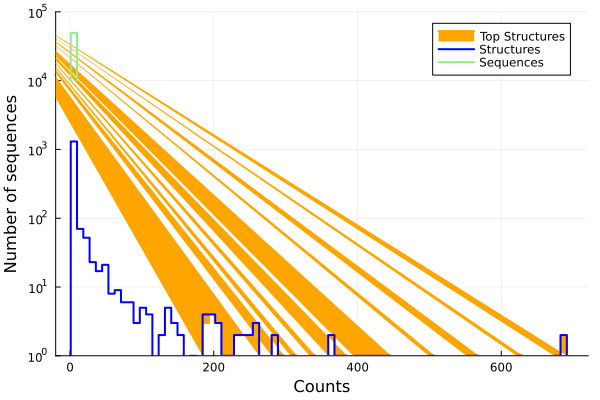

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


In [17]:
## Looking at the sampling of the population
his_range = range(1, 700, length=81)
stephist(str4Analysis.Total_Count[1:cutoffStr], yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", ma=0.2, lw=2, color=:orange, labels="Top Structures", fill=true)
stephist!(str4Analysis.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Structures")
stephist!(libAnalysisClean.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:lightgreen, labels="Sequences")


It is difficult to predict what oversampling of the structural space will look like, given the difference in density between the sequence landscape and the structure landscape.

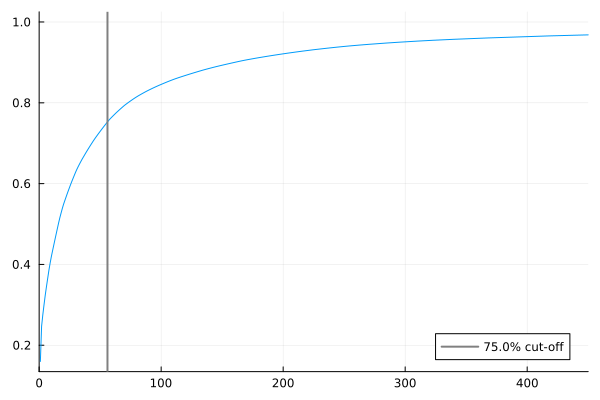

In [18]:
p1 = plot(plot_cdf, xaxis=[0,450])


In [21]:
## Creating a sample library with two lengths

## Loop1 long_library design
upstream_lib = "CGTAATCTGCTGCTTGCAAACAAAAAAACCACCG"
downstream_lib = "GCGGTGGTTTGTTTGCCGGATCAAGAG"

numberOfSequences = 1e5
randomLibrary = []

#total number of samples in the original library
total = sum(libAnalysisClean.Count)
subset_lib = filter(:Loop_length => n -> n == 46, lib_analysis)
subset = sum(subset_lib.Count) # Identifying the number of sequences in the subset

subSize = Int64(floor((subset/total)*numberOfSequences)) # splitting the resulting library

for sequence = 1:(numberOfSequences - subSize)
    insert = rand(["A", "C", "G", "T"], 15)
    sequence = ""
    for base in insert
        sequence = sequence * base
    end
    libraryElement = upstream_lib * sequence * downstream_lib
    push!(randomLibrary, libraryElement)
end
for sequence = 1:subSize
    insert = rand(["A", "C", "G", "T"], 14)
    sequence = ""
    for base in insert
        sequence = sequence * base
    end
    libraryElement = upstream_lib * sequence * downstream_lib
    push!(randomLibrary, libraryElement)
end

In [22]:
sampledDataset = instance_to_count(isolate_hairpin2(randomLibrary, upstream, downstream), wildtype)
sort!(sampledDataset, :Count, rev=true)

Row,Sequence_number,LoopI,Loop_length,Count,WT
,Any,Any,Any,Any,Any
1,1,ACAAAAAAACCACCGACCGTGCTAAAGGGTGCGGTGGTTTGTTTGCC,47,2,false
2,2,ACAAAAAAACCACCGGCGGCTCTAATGCTTGCGGTGGTTTGTTTGCC,47,2,false
3,3,ACAAAAAAACCACCGCCAAAACTATAAGGCGCGGTGGTTTGTTTGCC,47,2,false
4,4,ACAAAAAAACCACCGGCATCAGAGCGCTTCGCGGTGGTTTGTTTGCC,47,2,false
5,5,ACAAAAAAACCACCGAGCCTAGCAGATCGGGCGGTGGTTTGTTTGCC,47,2,false
6,6,ACAAAAAAACCACCGCCCATAATAGCGGGGGCGGTGGTTTGTTTGCC,47,1,false
7,7,ACAAAAAAACCACCGAGGTAACTGCTCAACGCGGTGGTTTGTTTGCC,47,1,false
8,8,ACAAAAAAACCACCGTCCGTTTGAAGGTTCGCGGTGGTTTGTTTGCC,47,1,false
9,9,ACAAAAAAACCACCGTGATCACTGCGCACTGCGGTGGTTTGTTTGCC,47,1,false


In [23]:
## Adding structural information to the dataframe - long
sampledDataset = rna_details(sampledDataset, downstream_RNAI)


LoadError: InterruptException:

#### Convenient point for saving partial results and for restarting later analysis

In [24]:
#save_name = "silicosample_" * file_name[1:end-6] * ".csv"

## Saving results
#CSV.write(save_name, sampledDataset)

## Opening saved results
save_name = "silicosample_Old_large_Loop1_rc.csv"
sampledDataset = CSV.read(save_name, DataFrame);


In [25]:
str4Analysis_random = extracting_structures(sampledDataset)
(plot_cdf_random,cutoffStr_random) = cdf_cutoff(str4Analysis_random, 0.75)
;

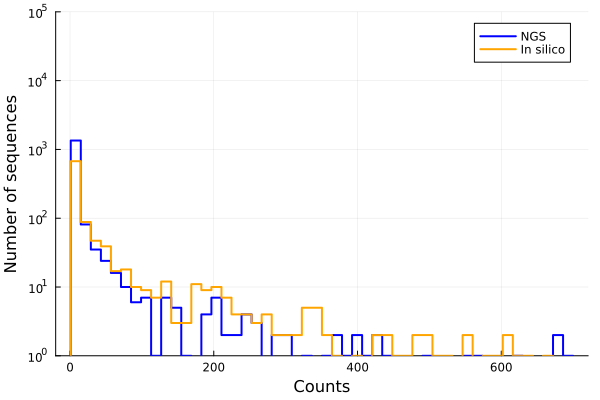

In [26]:
his_range = range(1, 700, length=51)
stephist(str4Analysis.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", ma=0.2, lw=2, color=:blue, labels="NGS")
stephist!(str4Analysis_random.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:orange, labels="In silico")

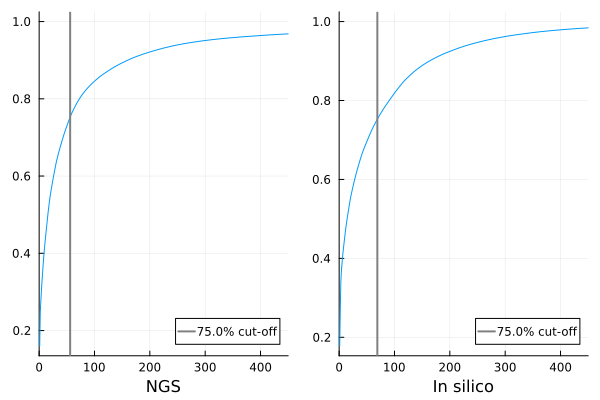

In [27]:
p1 = plot(plot_cdf, xaxis=[0,450], xlabel="NGS")
p2 = plot(plot_cdf_random, xaxis=[0,450], xlabel="In silico")
plot(p1, p2)

In [28]:
## Adding ranks to the data
rank_ngs = str4Analysis
rank_silico = str4Analysis_random

for n = 1:size(rank_ngs, 1)
    if n == 1
        rank_ngs.Str_number[n] = 1
    else
        if rank_ngs.Total_Count[n] == rank_ngs.Total_Count[n-1]
            rank_ngs.Str_number[n] = rank_ngs.Str_number[n-1]
        else
            rank_ngs.Str_number[n] = rank_ngs.Str_number[n-1]+1
        end
    end
end

for n = 1:size(rank_silico, 1)
    if n == 1
        rank_silico.Str_number[n] = 1
    else
        if rank_silico.Total_Count[n] == rank_silico.Total_Count[n-1]
            rank_silico.Str_number[n] = rank_silico.Str_number[n-1]
        else
            rank_silico.Str_number[n] = rank_silico.Str_number[n-1]+1
        end
    end
end

In [29]:
## Creating a set with the most frequent structures
frequentStructures = unique(vcat(str4Analysis.MFE_structure[1:cutoffStr], str4Analysis_random.MFE_structure[1:cutoffStr_random]))

## Creating a Dataframe to accomodate and compare the different structures
structureComparison = DataFrame([[],[],[],[],[],[]], ["MFE_structure", "NGS_count","NGS_rank", "Silico_count", "Silico_rank", "Str_Cluster"])
for n in frequentStructures
    
    ngs_count = filter(:MFE_structure => x -> x == n, str4Analysis)
    if size(ngs_count,1) > 0
        ngs_count = ngs_count.Total_Count[1]
    else
        ngs_count = 0
    end
    
    ngs_rank = filter(:MFE_structure =>x -> x == n, rank_ngs)
    if size(ngs_rank, 1) > 0
        ngs_rank = ngs_rank.Str_number[1]
    else
        ngs_rank = 0
    end
    
    silico_count = filter(:MFE_structure => x -> x == n, str4Analysis_random)
    if size(silico_count, 1) > 0
        silico_count = silico_count.Total_Count[1]
    else
        silico_count = 0
    end
    
    silico_rank = filter(:MFE_structure =>x -> x == n, rank_silico)
    if size(silico_rank, 1) > 0 
        silico_rank = silico_rank.Str_number[1]
    else 
        silico_rank = 0
    end
    
    new_entry = DataFrame([[n],[ngs_count],[ngs_rank],[silico_count],[silico_rank],[0]],["MFE_structure", "NGS_count","NGS_rank", "Silico_count", "Silico_rank", "Str_Cluster"])
    append!(structureComparison, new_entry)
end
;

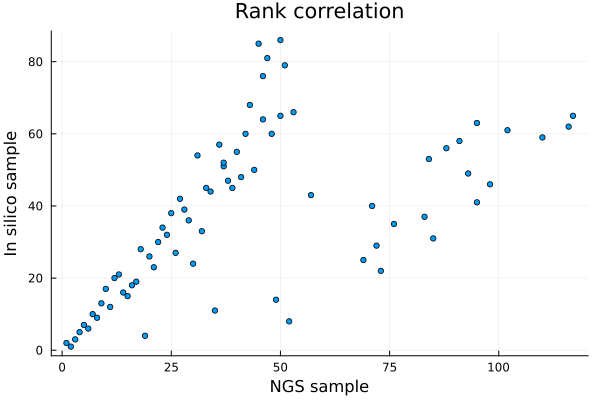

In [30]:
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 3,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample")

In [31]:
sort!(structureComparison, :Silico_rank) 

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Any
1,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,4317,2,17787,1,0
2,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,7951,1,9104,2,0
3,.((((.(((((((((((............))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1417,3,6764,3,0
4,.((((.((((((((((((..........)))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,559,19,3028,4,0
5,.((((.(((((((((.(.............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1249,4,1689,5,0
6,.((((.(((((((((.((...........))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1055,6,1633,6,0
7,.((((.(((((((((..((........))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1178,5,1550,7,0
8,.((((.(((((((((((((........))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,190,52,1285,8,0
9,.((((.(((((((((....((....))....))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,997,8,1247,9,0


In principle, significant deviations (either rank or counts) should be indicative of differences between populations. These could imply that certain structures are over-represented in NGS samples (could be the result of high plasmid copy number) or over-represented in the in silico sample (which could be the result of functional constraints). 
In the particular example above (short loop I), there are visible deviations from structures being overrepresented in the in silico sample. Below, I identify the structure and create two Dataframes containing NGS and in silico isolated structures. Sequence alignment could be used to identify possible biases in the NGS sample, that may indicate functional constraints.

In [32]:
furtherAnalysis = filter(:NGS_rank => n -> n == 116, structureComparison)

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Any
1,.((((.(((((((((((((((....))))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,33,116,274,62,0


In [33]:
NGS_furtherAnalysis = filter(:MFE_structure => n -> n == furtherAnalysis.MFE_structure[1], libAnalysisClean)
silico_furtherAnalysis = filter(:MFE_structure => n -> n == furtherAnalysis.MFE_structure[1], sampledDataset)
;

Multiple analyses are here then possible. Comparing some of the structural properties between the two datasets (e.g. MFE-energy and Mbp_dist) or making sequence-based comparisons (e.g. positional/dinucleotide biases). Here, I show comparisons with energy and structural flexibility, and I export the sequence data of both populations for offline analysis. 

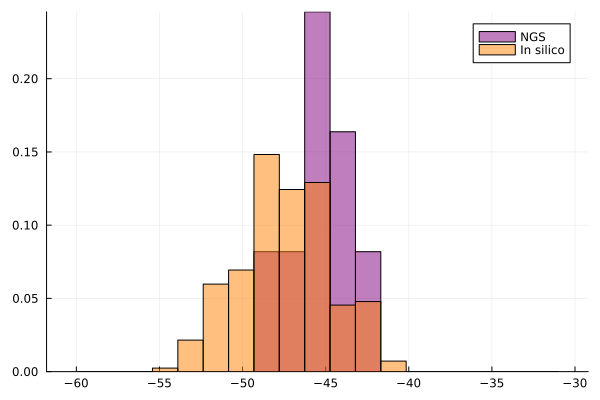

In [34]:
## Difference in MFE between NGS and in silico variants

his_range = range(-60, -31, length=20)
histogram(NGS_furtherAnalysis.MFE_energy, normalize=:pdf, bins=his_range, color=RGBA(0.5,0,0.5,0.5), labels="NGS")
histogram!(silico_furtherAnalysis.MFE_energy, normalize=:pdf, bins=his_range, color=RGBA(1,0.5,0,0.5), labels="In silico")


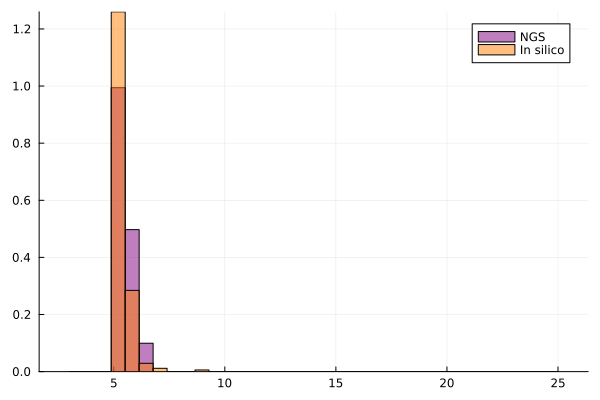

In [35]:
## Difference in Mbp_dist between NGS and in silico variants

his_range = range(3, 25, length=36)
histogram(NGS_furtherAnalysis.Mbp_dist, normalize=:pdf, bins=his_range, color=RGBA(0.5,0,0.5,0.5), labels="NGS")
histogram!(silico_furtherAnalysis.Mbp_dist, normalize=:pdf, bins=his_range, color=RGBA(1,0.5,0,0.5), labels="In silico")


#### Convenient point for saving partial results and for restarting later analysis

In [36]:
file_name[1:end-6]

"Processed_Old_large_Loop1_"

In [37]:
file_NGS = "NGS_FurtherAnalysis_" * file_name[1:end-6] * ".csv"
file_silico = "silico_FurtherAnalysis_" * file_name[1:end-6] * ".csv"
seq_NGS = "NGS_FurtherAnalysis_" * file_name
seq_silico = "silico_FurtherAnalysis_" * file_name




## Saving results
CSV.write(file_NGS, NGS_furtherAnalysis)
CSV.write(file_silico, silico_furtherAnalysis)


## Saving only the sequences and count as FASTA for Jalview analysis
record = []

for n = 1: size(NGS_furtherAnalysis, 1)
    new_record = parse(FASTARecord, ">$(NGS_furtherAnalysis.Sequence_number[n])_Sequence2_$(NGS_furtherAnalysis.Count[n])\n $(NGS_furtherAnalysis.LoopI[n])")
    push!(record, new_record)  
end

FASTA.Writer(open(seq_NGS, "w")) do writer # exports the FASTA records to a FASTA file
    for i = 1: size(record, 1)
    write(writer, record[i])
    end
end

for n = 1: size(silico_furtherAnalysis, 1)
    new_record = parse(FASTARecord, ">$(silico_furtherAnalysis.Sequence_number[n])_Sequence2_$(silico_furtherAnalysis.Count[n])\n $(silico_furtherAnalysis.LoopI[n])")
    push!(record, new_record)  
end

FASTA.Writer(open(seq_silico, "w")) do writer # exports the FASTA records to a FASTA file
    for i = 1: size(record, 1)
    write(writer, record[i])
    end
end


A variation to the analysis above could be to look at clustered structures rather than single structures. That would, in principle, identify structural features important for RNAI function - operating on the assumption that NGS data represents a sample of what is functionally active, whereas the in silico sequences need not fulfil that constraint. Below, I implement the clustering to see how feasible that would be.

In [38]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

seq_size = size(structureComparison, 1) # for convenience
;

In [39]:
# This looks at the difference between minimum free energy structures - closest to structural Hamming distance.
Struc_diff = zeros(Float16, seq_size, seq_size)
for i = 1: seq_size
    for j = i: seq_size
        structure_Hamming = tree_edit_dist(structureComparison.MFE_structure[i], structureComparison.MFE_structure[j])      
        Struc_diff[i,j] = structure_Hamming
        Struc_diff[j,i] = structure_Hamming
    end
end

In [40]:
## Saving distance matrices for reclustering
save_name = "StructureDistance_2ndmethod_" * file_name[1:end-6] * ".csv"

writedlm(save_name, Struc_diff, ",")
#check readdlm(save_name, Struc_diff, ",")

In [41]:
# creates clusters from the data above - sequence
Cluster_struct2 = hclust(Struc_diff, linkage=:complete, uplo=:U, branchorder=:r)
cluster_cut_off2 = 20 # defines the minimum degree of similarity within a cluster
structureComparison.Str_Cluster = Int16.(cutree(Cluster_struct2; h=cluster_cut_off2)) #k: number of clusters, h: maximum distance
;

In [42]:
structureComparison

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Int16
1,.((((.((((((((((..............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,4317,2,17787,1,1
2,.((((.(((((((((................))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,7951,1,9104,2,1
3,.((((.(((((((((((............))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1417,3,6764,3,1
4,.((((.((((((((((((..........)))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,559,19,3028,4,1
5,.((((.(((((((((.(.............)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1249,4,1689,5,1
6,.((((.(((((((((.((...........))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1055,6,1633,6,2
7,.((((.(((((((((..((........))..))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,1178,5,1550,7,2
8,.((((.(((((((((((((........))))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,190,52,1285,8,3
9,.((((.(((((((((....((....))....))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,997,8,1247,9,2


In [43]:
clusters = unique(structureComparison.Str_Cluster)
colorList = cgrad(:roma, size(clusters,1), categorical = true)
;

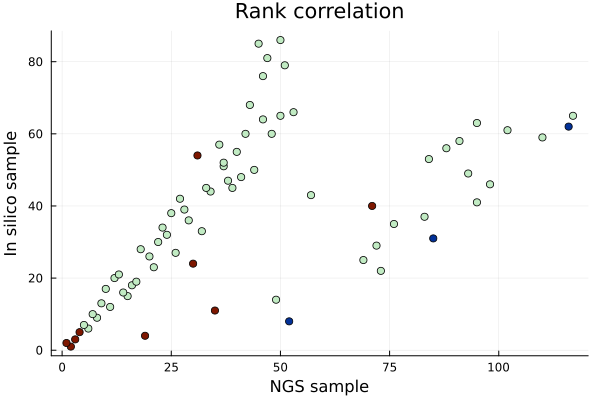

In [44]:
## Plotting all clusters
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample", color=colorList[structureComparison.Str_Cluster])

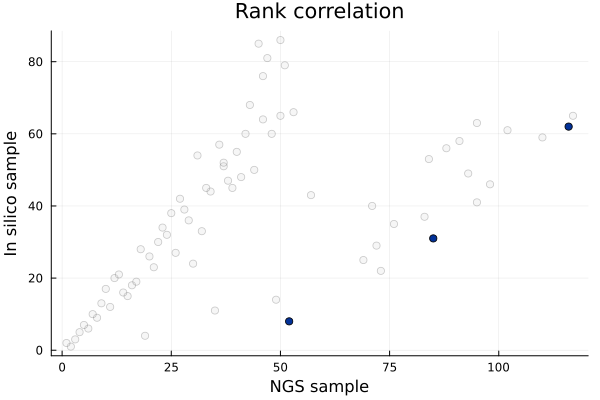

In [45]:
## Plotting individual clusters
cluster2see = 3

data2graph = filter(:Str_Cluster => n -> n == cluster2see, structureComparison)
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample",
    color=:lightgrey, ma=0.2)
scatter!(data2graph.NGS_rank, data2graph.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample",
    color=colorList[cluster2see])